## Cleaning Data


In [1]:
import pandas as pd
from IPython.display import display

data = pd.read_csv(r'UTSClustering.csv', encoding='ISO-8859-1')  

print("Data Awal (5 baris pertama):")
display(data.head())

# Mengatasi missing values terlebih dahulu
data_cleaned = data.dropna(subset=['CustomerID'])

# Mengisi missing value pada Description dengan 'Unknown'
data_cleaned['Description'].fillna('Unknown', inplace=True)

# Menghapus baris dengan Quantity dan UnitPrice negatif atau nol
data_cleaned = data_cleaned[(data_cleaned['Quantity'] > 0) & (data_cleaned['UnitPrice'] > 0)]

# Ubah InvoiceDate menjadi tipe datetime
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'], format='%m/%d/%Y %H:%M')

# Cek duplikasi data
duplicates = data_cleaned.duplicated().sum()
# Hilangkan duplikasi jika ada
data_cleaned.drop_duplicates(inplace=True)

# Tampilkan hasil cleaning data
print("\nData Setelah Cleaning (5 baris pertama):")
display(data_cleaned.head())

# Tampilkan ringkasan hasil cleaning
summary_cleaning = {
    "Total Baris Sebelum Cleaning": data.shape[0],
    "Total Baris Setelah Cleaning": data_cleaned.shape[0],
    "Jumlah Duplikasi Dihapus": duplicates,
    "Missing Values Setelah Cleaning": data_cleaned.isnull().sum().sum()
}

print("\nRingkasan Hasil Cleaning:")
for key, value in summary_cleaning.items():
    print(f"{key}: {value}")



Data Awal (5 baris pertama):


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


C:\Users\User\AppData\Local\Temp\ipykernel_14192\1851098203.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Description'].fillna('Unknown', inplace=True)



Data Setelah Cleaning (5 baris pertama):


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Ringkasan Hasil Cleaning:
Total Baris Sebelum Cleaning: 541909
Total Baris Setelah Cleaning: 392692
Jumlah Duplikasi Dihapus: 5192
Missing Values Setelah Cleaning: 0


## Feature Selection dan Feature Engineering

In [2]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder

# Copy data untuk seleksi fitur
data_fs = data_cleaned.copy()

# Pilih kolom numerik yang relevan untuk clustering
numeric_features = ['Quantity', 'UnitPrice']

# Seleksi fitur constant/quasi-constant dengan threshold rendah
selector = VarianceThreshold(threshold=0.01)
selector.fit(data_fs[numeric_features])
features_kept = selector.get_feature_names_out(numeric_features)

# Update daftar fitur numerik setelah threshold
numeric_features = list(features_kept)

# Encode kolom kategorikal untuk Chi-square test
label_encoder = LabelEncoder()
data_fs['Description_enc'] = label_encoder.fit_transform(data_fs['Description'])

# Seleksi fitur menggunakan Chi-square test pada kolom kategorikal
X_cat = data_fs[['Description_enc']]
y_cat = data_fs['Country']

chi_selector = SelectKBest(score_func=chi2, k='all')
chi_selector.fit(X_cat, y_cat)
chi_scores = chi_selector.scores_

# Susun skor Chi-square ke dalam DataFrame
chi_scores_df = pd.DataFrame({
    'Feature': ['Description'],
    'Chi2_Score': chi_scores
}).sort_values(by='Chi2_Score', ascending=False)

# Tampilkan hasil
print("Fitur Numerik yang Dipertahankan (Setelah Variance Threshold):")
print(numeric_features)

print("\nSkor Chi-square untuk Fitur Kategorikal:")
display(chi_scores_df)


Fitur Numerik yang Dipertahankan (Setelah Variance Threshold):
['Quantity', 'UnitPrice']

Skor Chi-square untuk Fitur Kategorikal:


,Feature,Chi2_Score
0,Description,124284.277077


## Next step Feature Engineering

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Ekstraksi fitur tambahan dari InvoiceDate
data_fe = data_cleaned.copy()
data_fe['DayOfWeek'] = data_fe['InvoiceDate'].dt.dayofweek
data_fe['Hour'] = data_fe['InvoiceDate'].dt.hour

# Normalisasi fitur numerik
scaler = StandardScaler()
data_fe[['Quantity_scaled', 'UnitPrice_scaled']] = scaler.fit_transform(data_fe[['Quantity', 'UnitPrice']])

# Sampling data sebelum TF-IDF untuk efisiensi memori
data_sample_fe = data_fe.sample(n=10000, random_state=42).reset_index(drop=True)

# TF-IDF pada data yang telah disampling
tfidf = TfidfVectorizer(max_features=100)
description_tfidf_sample = tfidf.fit_transform(data_sample_fe['Description'])

# Konversi hasil TF-IDF ke DataFrame
tfidf_sample_df = pd.DataFrame(description_tfidf_sample.toarray(), columns=[f'TFIDF_{i}' for i in range(description_tfidf_sample.shape[1])])

# Gabungkan semua fitur
data_final_sample = pd.concat([
    data_sample_fe[['Quantity_scaled', 'UnitPrice_scaled', 'DayOfWeek', 'Hour']].reset_index(drop=True),
    tfidf_sample_df.reset_index(drop=True)
], axis=1)

# Tampilkan hasil akhir feature engineering dengan data sampel
display(data_final_sample.head())

data_final_sample.shape


,Quantity_scaled,UnitPrice_scaled,DayOfWeek,Hour,TFIDF_0,TFIDF_1,TFIDF_2,TFIDF_3,TFIDF_4,TFIDF_5,...,TFIDF_90,TFIDF_91,TFIDF_92,TFIDF_93,TFIDF_94,TFIDF_95,TFIDF_96,TFIDF_97,TFIDF_98,TFIDF_99
0,-0.039446,-0.007909,3,12,0.0,0.0,0.000000,0.0,0.527125,0.0,...,0.0,0.0,0.426119,0.0,0.0,0.0,0.484063,0.0,0.0,0.0
1,-0.061608,0.082012,0,13,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.060281,-0.084342,0,12,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.060281,-0.115814,0,12,0.0,0.0,0.489093,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,-0.006204,-0.066358,3,14,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


(10000, 104)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Score
0,KMeans,0.245604,1.251174,4613.833430
1,AgglomerativeClustering,0.244462,1.133668,4816.254052
2,DBSCAN,-0.583800,1.414681,10.597295
3,GaussianMixture,-0.020437,18.666221,15.281266
4,SpectralClustering,0.242437,1.006137,3984.787201


C:\Users\User\AppData\Local\Temp\ipykernel_14192\1776564268.py:46: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  results_df.set_index('Model').plot(kind='bar', ax=ax, subplots=True, layout=(1,3), legend=False)


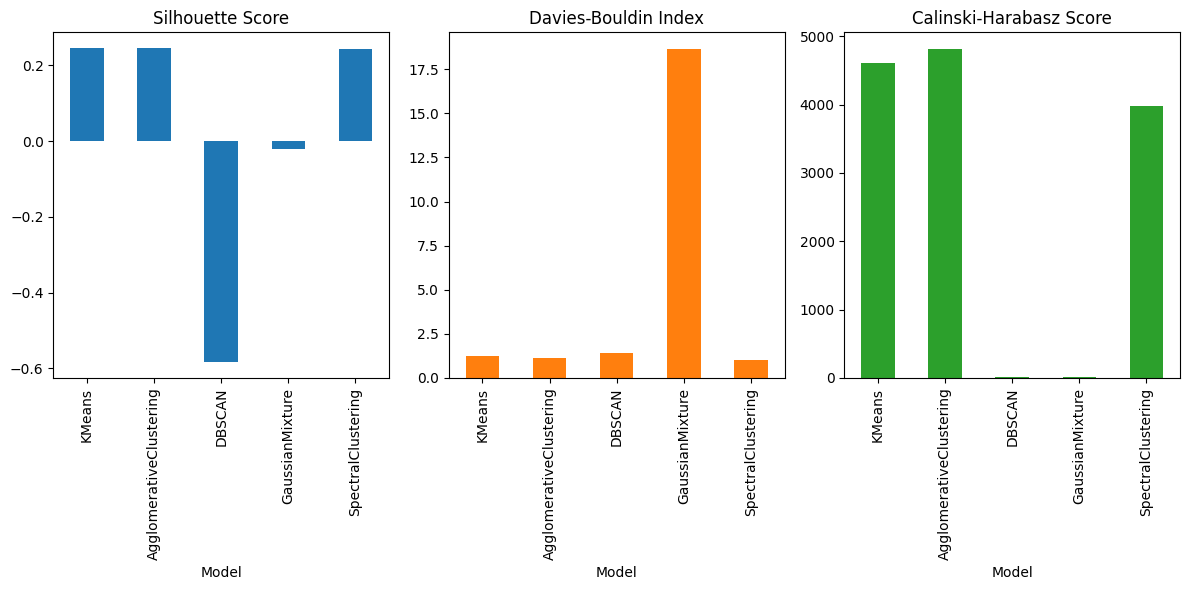

In [4]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

# Persiapan data untuk clustering
X = data_final_sample.values

# Menyiapkan model clustering
models = {
    'KMeans': KMeans(n_clusters=5, random_state=42),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=5),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'GaussianMixture': GaussianMixture(n_components=5, random_state=42),
    'SpectralClustering': SpectralClustering(n_clusters=5, random_state=42, affinity='nearest_neighbors')
}

# Menyimpan hasil evaluasi
results = []

# Fit dan evaluasi masing-masing model
for name, model in models.items():
    if name == 'GaussianMixture':
        labels = model.fit_predict(X)
    else:
        labels = model.fit(X).labels_
    
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    db_index = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
    ch_score = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1

    results.append({
        'Model': name,
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': db_index,
        'Calinski-Harabasz Score': ch_score
    })

# Menampilkan hasil evaluasi clustering
results_df = pd.DataFrame(results)
display(results_df)

# Visualisasi hasil evaluasi clustering
fig, ax = plt.subplots(figsize=(12, 6))
results_df.set_index('Model').plot(kind='bar', ax=ax, subplots=True, layout=(1,3), legend=False)
plt.tight_layout()
plt.show()


##  clustering and Evaluation

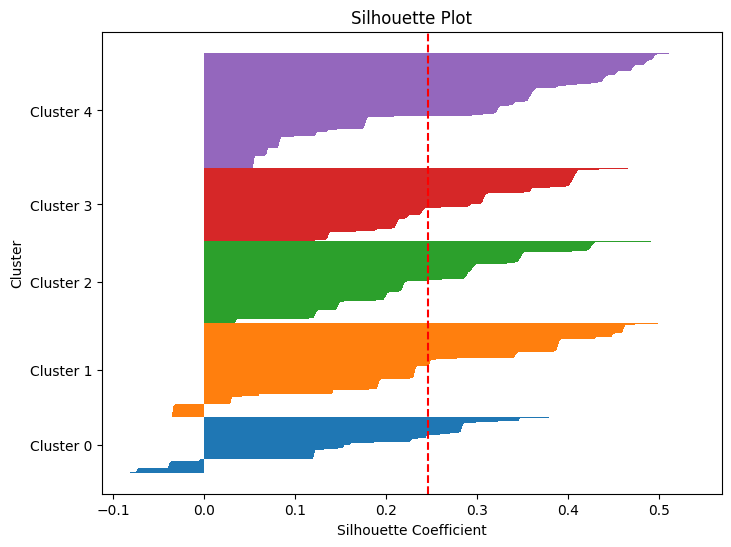

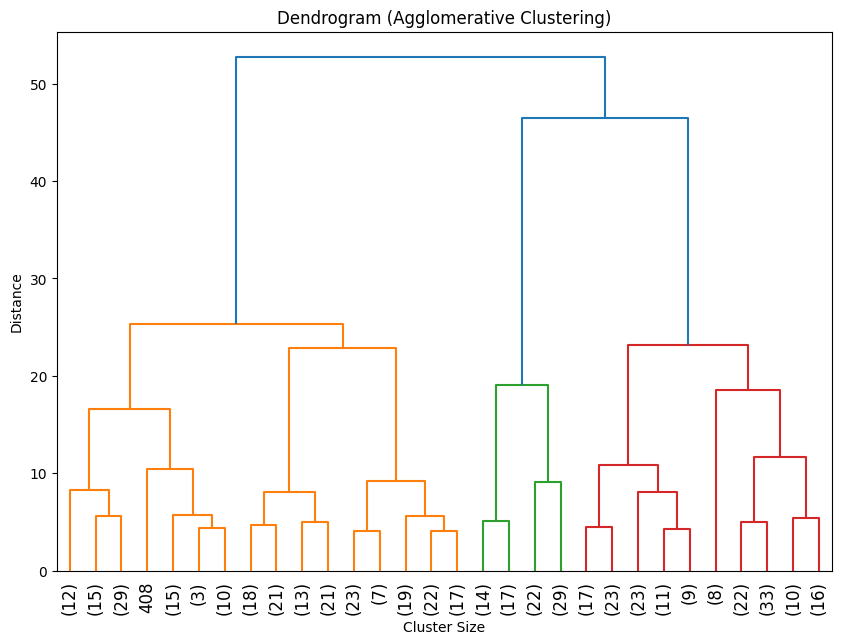

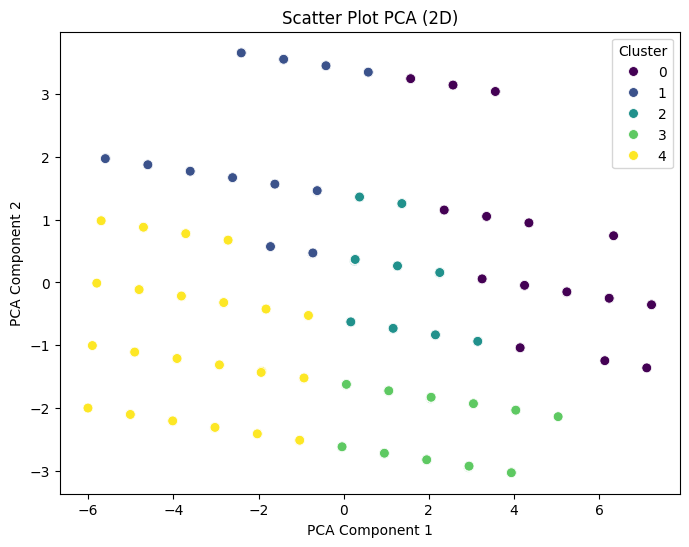

In [6]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

# Pilih model terbaik berdasarkan Silhouette Score (asumsi KMeans untuk contoh visualisasi)
best_model = KMeans(n_clusters=5, random_state=42)
labels = best_model.fit_predict(X)

# 1. Silhouette Plot
silhouette_vals = silhouette_samples(X, labels)
y_lower, y_upper = 0, 0
yticks = []
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(np.unique(labels)):
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(np.mean(silhouette_vals), color="red", linestyle="--")
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.yticks(yticks, [f'Cluster {i}' for i in np.unique(labels)])
plt.title('Silhouette Plot')
plt.show()

# 2. Dendrogram (Agglomerative Clustering)
linked = linkage(X[:500], method='ward')  # sample kecil karena dendrogram sangat intensif memori
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=12.)
plt.title('Dendrogram (Agglomerative Clustering)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

# 3. Scatter Plot PCA (reduksi 2D untuk visualisasi cluster)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='viridis', s=50)
plt.title('Scatter Plot PCA (2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
